In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
CONFIGURATIONS = [
    {'num_layers': 7, 'optimizer': optimizers.RMSprop(), 'batch_size': 128},
    {'num_layers': 7, 'optimizer': optimizers.Adam(), 'batch_size': 64},
    {'num_layers': 5, 'optimizer': optimizers.SGD(momentum=0.9), 'batch_size': 256},
]

In [3]:
def residual_block(x, filters, downsample=False):
    identity = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, (3,3), strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3,3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters, (1,1), strides=2, padding='same', kernel_initializer='he_normal')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    return x

In [4]:
def build_resnet(input_shape, num_classes, n=3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    for filters in [16, 32, 64]:
        for i in range(n):
            x = residual_block(x, filters, downsample=(i == 0 and filters != 16))

    x = layers.AveragePooling2D(pool_size=(8,8))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [5]:
# Code for using dataset CIFAR 10

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
# Code for using dataset CIFAR 100

(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
num_classes = 100

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
results = {}
configurations = {}

for config in CONFIGURATIONS:
    n = config['num_layers']
    opt = config['optimizer']
    batch_size = config['batch_size']
    epochs = 20

    config_key = f'ResNet-{n} ({opt.__class__.__name__})'
    print(f'Training {config_key}')
    model = build_resnet((32, 32, 3), num_classes, n=n)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
    model.save(f'resnet_n{n}_{opt.__class__.__name__}_cifar100.h5')

    loss, acc = model.evaluate(x_test, y_test)
    results[config_key] = (history.history, acc)
    configurations[config_key] = {
        'num_layers': n,
        'optimizer': opt.__class__.__name__,
        'batch_size': batch_size,
        'epochs': 20,
        'final_accuracy': acc,
        'history': history.history
    }

Training ResNet-7 (RMSprop)
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.3560 - loss: 1.7843 - val_accuracy: 0.4051 - val_loss: 1.7635
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.6089 - loss: 1.0760 - val_accuracy: 0.5680 - val_loss: 1.2712
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.7160 - loss: 0.7994 - val_accuracy: 0.6590 - val_loss: 1.0425
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.7721 - loss: 0.6478 - val_accuracy: 0.7107 - val_loss: 0.8553
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8090 - loss: 0.5438 - val_accuracy: 0.6922 - val_loss: 0.9229
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8397 - loss: 0.4576 - val_accuracy: 0.5930 - val_loss: 1.5854
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8643 - loss: 0.3871 - val_accuracy: 0.7083 - val_loss: 0.9449
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accura

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7149 - loss: 1.4148
Training ResNet-7 (Adam)
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 87s 58ms/step - accuracy: 0.3736 - loss: 1.7672 - val_accuracy: 0.5573 - val_loss: 1.2846
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.6458 - loss: 0.9989 - val_accuracy: 0.6218 - val_loss: 1.1001
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.7264 - loss: 0.7728 - val_accuracy: 0.6533 - val_loss: 1.0435
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.7760 - loss: 0.6419 - val_accuracy: 0.7438 - val_loss: 0.7378
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.8089 - loss: 0.5446 - val_accuracy: 0.6829 - val_loss: 0.9424
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.8365 - loss: 0.4703 - val_accuracy: 0.7517 - val_loss: 0.7497
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.8567 - loss: 0.4129 - val_accuracy: 0.7637 - val_los

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7889 - loss: 0.9371
Training ResNet-5 (SGD)
Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 45s 127ms/step - accuracy: 0.2728 - loss: 2.0897 - val_accuracy: 0.3187 - val_loss: 1.9837
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.4893 - loss: 1.3871 - val_accuracy: 0.4171 - val_loss: 1.7221
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.5752 - loss: 1.1670 - val_accuracy: 0.4902 - val_loss: 1.4494
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.6264 - loss: 1.0304 - val_accuracy: 0.5233 - val_loss: 1.4823
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.6745 - loss: 0.9169 - val_accuracy: 0.5569 - val_loss: 1.3265
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7176 - loss: 0.8064 - val_accuracy: 0.6471 - val_loss: 1.0013
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7452 - loss: 0.7216 - val_accuracy: 0.6617 - val_los

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5906 - loss: 2.0036


In [7]:
def plot_comparisons(results):
    plt.figure(figsize=(12, 6))
    for key, (history, acc) in results.items():
        plt.plot(history['val_accuracy'], label=f'{key} (Final Acc: {acc:.4f})')

    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Comparison of ResNet Architectures and Optimizers in CIFAR 10 dataset')
    plt.show()

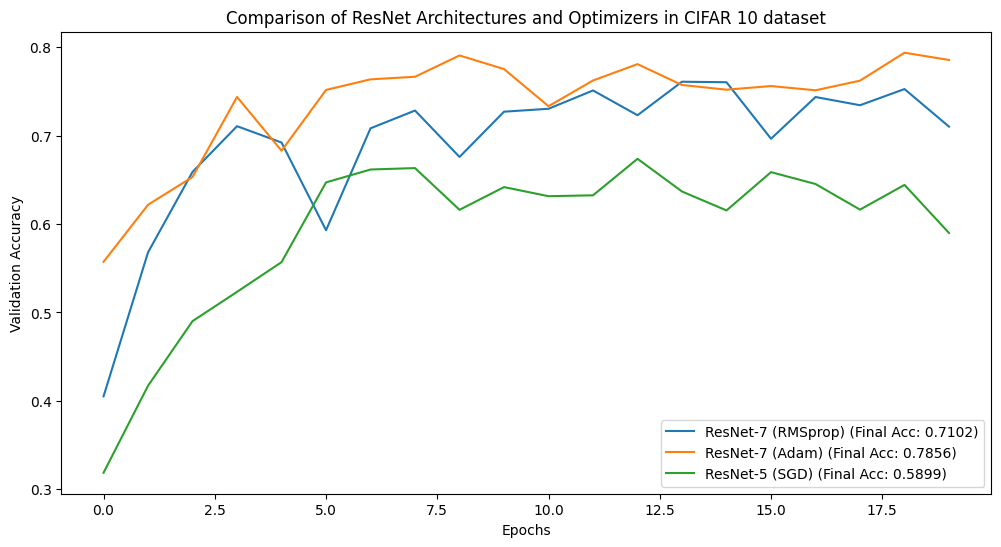

In [8]:
plot_comparisons(results)

In [ ]:
def plot_comparisons(results):
    plt.figure(figsize=(12, 6))
    for key, (history, acc) in results.items():
        plt.plot(history['val_accuracy'], label=f'{key} (Final Acc: {acc:.4f})')

    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.title('Comparison of ResNet Architectures and Optimizers in CIFAR 100 dataset')
    plt.show()

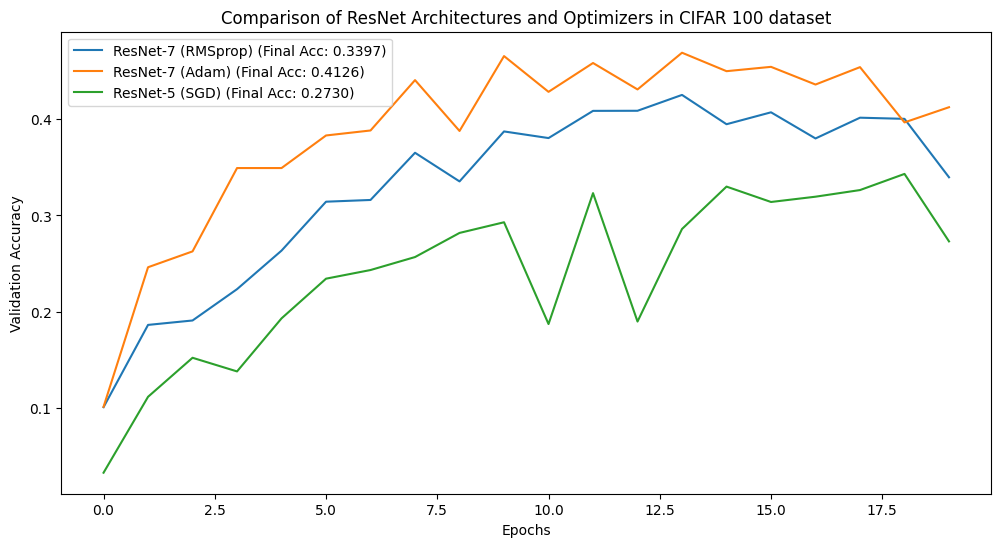

In [ ]:
plot_comparisons(results)

In [ ]:
for config, details in configurations.items():
    print(f'Configuration: {config}')
    for key, value in details.items():
        if key != 'history':  # Avoid printing full history
            print(f'  {key}: {value}')

Configuration: ResNet-7 (RMSprop)
  num_layers: 7
  optimizer: RMSprop
  batch_size: 128
  epochs: 20
  final_accuracy: 0.33970001339912415
Configuration: ResNet-7 (Adam)
  num_layers: 7
  optimizer: Adam
  batch_size: 64
  epochs: 20
  final_accuracy: 0.41260001063346863
Configuration: ResNet-5 (SGD)
  num_layers: 5
  optimizer: SGD
  batch_size: 256
  epochs: 20
  final_accuracy: 0.27300000190734863
